# Tópicos de Minería de datos - TP 2
## Autora: Aldana Zarate

# Imports

In [ ]:
install.packages("gtools")
install.packages("randomForest")
install.packages("kernlab")
library(gtools)
library(RColorBrewer)
library(MASS)

# Funciones proveidas en el enunciado

In [ ]:
#-------------------------------------------------------------------------------------
# AVISO: codigo de demostracion
# No es optimo, no es la mejor solucion
#
#Funcion general para forward greedy feature selection
#input:
# x,y inputs y targets
# method es una funcion externa que estima el classification error para un dado clasificador con esos datos
# ... parametros extra para el metodo method
#output:
#list.feat <-numero de orden de importancia de las variables, primero la mas relevante

#-------------------------------------------------------------------------------------
forward.ranking <- function(x,y,method,verbosity=0,... )
{

	max.feat<-dim(x)[2]		#total de features
	num.feat<-1				#numero actual de features
	list.feat<-1:max.feat   #lista para guardar los features elegidos, inicializo como llegaron

	#ranking inicial: elijo la variable con menor error de prediccion
	class.error<-double(max.feat)   #inicializo el vector para guardar el error de cada modelo
	#para cada i, creo el dataset con esa variable sola, entreno un modelo y le mido el error, que lo guardo en class.error[i]
	for(i in 1:max.feat){
		x.train<-x[,i,drop=F]
		class.error[i] <- do.call(method, c(list(x.train, y), list(...)) )
	}
	#guardo la variable con minimo error como primera en mi lista de elegidas. Guardo una lista keep.feat con las que me quedan para seguir eligiendo.
	list.feat[1]<-which.min(class.error)
	keep.feat<-sort(class.error,decreasing=FALSE,index=T)$ix[-1] # esto es una lista de indices, ordenadas desde la mas importante a la menos

	if(verbosity>1) cat("\nFirst feature: ",list.feat[1],"\n")

    #loop principal. A cada paso agrego todas las variables disponibles, de a una, le mido el error y me quedo con la de minimo error. Hasta llegar a meter todas.
	while(num.feat<max.feat){
        #class.error guarda el error de cada modelo. Son max.feat-num.feat modelos.
		class.error<-double(max.feat-num.feat)
		#para cada variable que me queda, la agrego a la lista del paso anterior, entreno el modelo y le mido el error.
		for(i in 1:(max.feat-num.feat)){
		    features<-c(list.feat[1:num.feat],keep.feat[i])
			x.train<-x[,features]
			class.error[i] <- do.call(method, c(list(x.train, y), list(...)) )
		}
		if(verbosity>2) cat("\nFeatures:\n",keep.feat,"\nErrors:\n",class.error)
		#me quedo con el modelo de minimo error, guardo ese feature en la lista de las elegidas, lo saco de la lista de las que quedan.
		best.index<-which.min(class.error)
		list.feat[num.feat+1]<-keep.feat[best.index]
		if(verbosity>2) cat("\n---------\nStep ",1+num.feat,"\nFeature ",best.index) # modifiqué el nro de verbosity aca para poder usarla en el ej 2, muy granular me pareció

		keep.feat<-keep.feat[-best.index]
		if(verbosity>2) cat("\nNew search list: ",keep.feat)
		num.feat<-num.feat+1 #proximo paso
	}

	if(verbosity>1){
		cat("\n---------\nFinal ranking ",num.feat," features.")
		cat("\nFeatures: ",list.feat,"\n")
	}

 	return(list.feat)

}


#---------------------------------------------------------------------------
#random forest error estimation (OOB) for greedy search
#---------------------------------------------------------------------------
rf.est <- function(x.train,y,equalize.classes=TRUE,tot.trees=500,mtry=0)
{
	if(mtry<1) mtry<-floor(sqrt(dim(x.train)[2]))
	prop.samples<-table(y)
	if(equalize.classes) prop.samples<-rep(min(prop.samples),length(prop.samples))
	return( randomForest(x.train,y,mtry=mtry,ntree=tot.trees,sampsize=prop.samples)$err.rate[tot.trees] )
}

#---------------------------------------------------------------------------
#LDA error estimation (LOO) for greedy search
#---------------------------------------------------------------------------
lda.est <- function(x.train,y)
{
	m.lda <- lda(x.train,y,CV=TRUE)
	return(error.rate( y , m.lda$class))
}
error.rate <- function(dataA, dataB) sum( dataA != dataB ) / length(dataB)

#---------------------------------------------------------------------------
#SVM error estimation (internal CV) for greedy search
#---------------------------------------------------------------------------
svm.est <- function(x.train,y,type="C-svc",kernel="vanilladot",C=1,cross = 4)
{
	return ( ksvm(x.train, y, type=type,kernel=kernel,C=C,cross = cross)@cross )
}


#---------------------------------------------------------------------------
#random forest ranking method for rfe.
#---------------------------------------------------------------------------
imp.rf <- function(x.train,y,equalize.classes=TRUE,tot.trees=500,mtry=0)
{
	if(mtry<1) mtry<-floor(sqrt(dim(x.train)[2]))
	prop.samples<-table(y)
	if(equalize.classes) prop.samples<-rep(min(prop.samples),length(prop.samples))

	m.rf<-randomForest(x.train,y,ntree=tot.trees,mtry=mtry,sampsize=prop.samples,importance=TRUE)
	imp.mat<-importance(m.rf)
	imp.col<-dim(imp.mat)[2]-1
	rank.list<-sort(imp.mat[,imp.col],decreasing=FALSE,index=T)
	return(list(feats=rank.list$ix,imp=rank.list$x))
}


#---------------------------------------------------------------------------
#linear svm ranking method for rfe. Using kernlab. Multiclass
#---------------------------------------------------------------------------
imp.linsvm <- function(x.train,y,C=100)
{
	num.feat<-dim(x.train)[2]
	tot.problems<-nlevels(y)*(nlevels(y)-1)/2

	invisible(capture.output(m.svm <- ksvm(as.matrix(x.train), y, type="C-svc",kernel="vanilladot",C=C))) # capturo los mensajes "Setting default kernel parameters"

	w<-rep(0.0,num.feat)
	for(i in 1:tot.problems) for(feat in 1:num.feat)
		w[feat]<-w[feat]+abs(m.svm@coef[[i]] %*% m.svm@xmatrix[[i]][,feat])
	rank.list<-sort(w,decreasing=FALSE,index=T)
	return(list(feats=rank.list$ix,imp=rank.list$x))
}


#---------------------------------------------------------------------------
#Ejemplo de uso de las funciones de seleccion
#---------------------------------------------------------------------------
library(randomForest)
library(kernlab)
library(MASS)

#demo: aplicar el wrapper a los datos de iris
data(iris)
FORW.rf <-forward.ranking(iris[,-5],iris[,5],method="rf.est" ,tot.trees=100,equalize.classes=F)
FORW.lda<-forward.ranking(iris[,-5],iris[,5],method="lda.est")


#---------------------------------------------------------------------------
#Codigo con datasets de ejemplo y para el TP2
#---------------------------------------------------------------------------
#hacer una funcion que cree datos, 2 clases (-1 y 1,n puntos de cada una), d dimensiones, de ruido uniforme [-1,1], con la clase al azar

crea.ruido.unif<-function(n=100,d=2){
x<-runif(2*n*d,min=-1)	#genero los datos
dim(x)<-c(2*n,d)
return(cbind(as.data.frame(x),y=factor(rep(c(-1,1),each=n))))	#le agrego la clase
}

#---------------------------------------------------------------------------
#CREA DATASET datosB
#Dataset artificial con orden de importancia: 8-6-4-2
#---------------------------------------------------------------------------
d<-10
n<-1000
datos<-crea.ruido.unif(n=n,d=d)

#tomar 50% de los datos al azar, y hacer que la clase sea el signo de la 8 variable
shuffle<-sample(1:dim(datos)[1])
sub<-shuffle[1:dim(datos)[1]*0.5]
datos[sub,d+1]<-sign(datos[sub,8])
#tomar 20% de los datos al azar (fuera de los anteriores), y hacer que la clase sea el signo de la 6 variable
sub<-shuffle[(dim(datos)[1]*0.5):(dim(datos)[1]*0.7)]
datos[sub,d+1]<-sign(datos[sub,6])
#tomar 10% de los datos al azar, y hacer que la clase sea el signo de la 4 variable
sub<-shuffle[(dim(datos)[1]*0.7):(dim(datos)[1]*0.8)]
datos[sub,d+1]<-sign(datos[sub,4])
#tomar 5% de los datos al azar, y hacer que la clase sea el signo de la 2 variable
sub<-shuffle[(dim(datos)[1]*0.8):(dim(datos)[1]*0.85)]
datos[sub,d+1]<-sign(datos[sub,2])
datos[,d+1]<-factor(datos[,d+1])

datosA<-datos

#---------------------------------------------------------------------------
#CREA DATASET datosB
#Dataset artificial con dos variables relevantes (1-2) y dos variables que son importantes pero que no resuelven el problema (3-4)
#---------------------------------------------------------------------------
#generar n=100,d=8
d<-8
n<-1000
datos<-crea.ruido.unif(n=n,d=d)
#hacer que la clase sea el xor de las 2 primeras variables (es usando el signo)
datos[,d+1]<-sign(datos[,1]*datos[,2])
#hacer que las variables 3 y 4 tengan un 50% de correlacion con la clase
shuffle<-sample(1:dim(datos)[1])
sub<-shuffle[1:dim(datos)[1]*0.5]
datos[sub,3]<-abs(datos[sub,3])*datos[sub,d+1]
shuffle<-sample(1:dim(datos)[1])
sub<-shuffle[1:dim(datos)[1]*0.5]
datos[sub,4]<-abs(datos[sub,4])*datos[sub,d+1]
datos[,d+1]<-factor(datos[,d+1])

datosB<-datos

# Ejercicio 1


## a) Wrapper greedy backward

In [5]:
#Funcion general para backward greedy feature selection
#input:
# x,y inputs y targets
# method es una funcion externa que estima el classification error para un dado clasificador con esos datos
# ... parametros extra para el metodo method
#output:
#list.feat <-numero de orden de importancia de las variables, primero la mas relevante

#-------------------------------------------------------------------------------------
backward.ranking <- function(x,y,method,verbosity=0,... )
{

	max.feat<-dim(x)[2]		#total de features
	num.feat<-1				#numero actual de features sacadas
	list.feat<-1:max.feat   #lista para guardar los features elegidos, inicializo como llegaron

	#ranking inicial: quito la variable con menor error de prediccion, la mando al fondo de la lista (es la menor importante)
	class.error<-double(max.feat)   #inicializo el vector para guardar el error de cada modelo
	#para cada i, creo el dataset con todas las variables menos la i, entreno un modelo y le mido el error, que lo guardo en class.error[i]
  # i variable que quito
	for(i in 1:max.feat){
		x.train<-x[,-i]
		class.error[i] <- do.call(method, c(list(x.train, y), list(...)) )
	}
	#guardo la variable con minimo error como ultima en mi lista de elegidas (al hacer que baje poco el error es la menos importante).
  #Guardo una lista keep.feat con las que me quedan para seguir quitando.
	list.feat[max.feat]<-which.min(class.error)
	keep.feat<-sort(class.error,decreasing=FALSE,index=T)$ix[-1] # esto es una lista de indices, ordenadas desde la mas importante a la menos

	if(verbosity>1) cat("\nLeast important feature: ",list.feat[max.feat],"\n")

    #loop principal. A cada paso quito todas las variables disponibles, de a una, le mido el error y saco la de minimo error. Hasta llegar a sacar todas.
	while(num.feat<max.feat-1){
        #class.error guarda el error de cada modelo. Son max.feat-num.feat modelos.
		class.error<-double(max.feat-num.feat)
		#para cada variable que me queda, pruebo de quitarla, entreno el modelo y le mido el error.
		for(i in 1:(max.feat-num.feat)){
		  features<-keep.feat[-i]
			x.train<-as.matrix(x[,features])
			class.error[i] <- do.call(method, c(list(x.train, y), list(...)) )
		}
		if(verbosity>2) cat("\nFeatures:\n",keep.feat,"\nErrors:\n",class.error)
		#me quedo con el modelo de minimo error, guardo ese feature en la lista de las elegidas avanzando un lugar hacia la izq, lo saco de la lista de las que quedan.
		best.index<-which.min(class.error)
		list.feat[max.feat-num.feat]<-keep.feat[best.index]
		if(verbosity>2) cat("\n---------\nStep ",1+num.feat,"\nFeature ",best.index)

		keep.feat<-keep.feat[-best.index]
		if(verbosity>2) cat("\nNew search list: ",keep.feat)
		num.feat<-num.feat+1 #proximo paso
	}

  # La variable que más error genera al sacarla va en la primera posición:

  list.feat[1]<-keep.feat[1]

	if(verbosity>1){
		cat("\n---------\nFinal ranking ",num.feat+1," features.")
		cat("\nFeatures: ",list.feat,"\n")
	}

 	return(list.feat)

}

## b) Filter con test no-paramétrico (Kruskal-Wallis)

In [6]:
kruskal.ranking <- function(x, y, verbosity = 0){
  max.feat<-dim(x)[2]		#total de features
  ranking <- double(max.feat)
  for (i in 1:max.feat){
    feature <- x[,i]
    ranking[i] <- kruskal.test(feature,y)$statistic
  }

  # Obtenemos las variables
  ranking <- sort(ranking, decreasing=TRUE, index=T)$ix

  if(verbosity>1){
		cat("\n---------\nFinal ranking ",max.feat," features.")
		cat("\nFeatures: ",ranking,"\n")
	}

  return(ranking)

}

## c) RFE

In [7]:
rfe.ranking <- function(x, y, method, verbosity=0, ...){
  max.feat <- dim(x)[2]
  ranking <- double(max.feat) # para guardar los rankings
  actual.features <- 1:max.feat # conjunto donde se van a ir eliminando las variables

  for(i in 1:max.feat){
    x.train <- as.matrix(x[,actual.features])  # variables que vamos a usar en el modelo
    rank <- do.call(method, c(list(x.train, y), list(...)) )

    lowest.rank <- rank$feats[1] # nro de variable con el ranking más bajo

    ranking[max.feat - i + 1] = actual.features[lowest.rank]  # mando al final la variable que menos modifica el modelo
    actual.features <- actual.features[-lowest.rank]  # elimino la variable con el ranking más bajo
  }

   if(verbosity>1){
		cat("\n---------\nFinal ranking ",max.feat," features.")
		cat("\nFeatures: ",ranking,"\n")
	}

  return(ranking)
}

# Ejercicio 2)


## DatosA


### Proyección

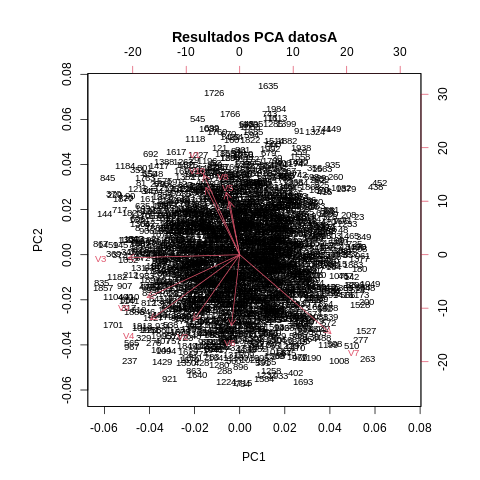

In [ ]:
datosA[1:5,]
datosA.x <- datosA[,-11]
datosA.y <- datosA[,11]

datosA.pca <- prcomp(datosA.x, scale=TRUE)
biplot(datosA.pca,choices=c(1,2),cex=0.8, main='Resultados PCA datosA')

El gráfico obtenido está bastante difícil de interpretar, pero por lo que puedo visualizar, se nota un agrupamiento entre las variables:
- V8, V5 y V10
- V3 y V1
- V4, V2 y V6

### Selección de variables


In [ ]:
cat("\n > Forward ranking RF \n")
FORW.rf <- forward.ranking(datosA.x,datosA.y,method="rf.est" ,tot.trees=100,equalize.classes=F, verbosity=2)
cat("\n > Forward ranking LDA \n")
FORW.lda <- forward.ranking(datosA.x,datosA.y,method="lda.est", verbosity=2)

cat("\n ----------------------------------------- \n")

cat("\n > Backward ranking RF \n")
BACK.rf <- backward.ranking(datosA.x,datosA.y,method="rf.est" ,tot.trees=100,equalize.classes=F, verbosity=2)
cat("\n > Backward ranking LDA \n")
BACK.lda <- backward.ranking(datosA.x,datosA.y,method="lda.est", verbosity=2)

cat("\n ----------------------------------------- \n")

cat("\n > Kruskal-Wallis \n")
KW <- kruskal.ranking(datosA.x, datosA.y, verbosity = 2)

cat("\n ----------------------------------------- \n")

cat("\n > RFE random forest \n")
RFE.rf <- rfe.ranking(datosA.x,datosA.y,method="imp.rf", tot.trees=100, verbosity=2)
cat("\n > RFE SVM \n")
RFE.linsvm <- rfe.ranking(datosA.x,datosA.y,method="imp.linsvm", verbosity=2)


 > Forward ranking RF 

First feature:  8 

---------
Final ranking  10  features.
Features:  8 6 10 2 4 7 3 5 1 9 

 > Forward ranking LDA 

First feature:  8 

---------
Final ranking  10  features.
Features:  8 9 7 10 1 5 3 2 6 4 

 ----------------------------------------- 

 > Backward ranking RF 

Least important feature:  5 

---------
Final ranking  10  features.
Features:  8 3 10 9 7 4 6 1 2 5 

 > Backward ranking LDA 

Least important feature:  4 

---------
Final ranking  10  features.
Features:  8 7 5 3 2 6 1 9 10 4 

 ----------------------------------------- 

 > Kruskal-Wallis 

---------
Final ranking  10  features.
Features:  8 6 4 2 3 5 7 9 1 10 

 ----------------------------------------- 

 > RFE random forest 

---------
Final ranking  10  features.
Features:  8 6 4 2 7 10 1 9 5 3 

 > RFE SVM 

---------
Final ranking  10  features.
Features:  8 6 4 2 3 1 7 5 10 9 


Podemos observar que todos los métodos identificaron correctamente a la 8 como la variable más importante. Sin embargo, solo Kruskal-Wallis y RFE (tanto usando RF como SVM) lograron identificar a todas las variables importantes siguiendo su orden 8,6,4,2. En forward podemos ver que la variable 6 usando RF obtuvo correctamente el segundo puesto, pero usando LDA está casi al final (antes de la 4 que quedó última, hecho que también vale la pena mencionar); con lo que en este caso usar RF fue ampliamente superior a usar LDA. Por el lado del backward, ambos resultados son similares, y tampoco demasiado buenos.



## DatosB

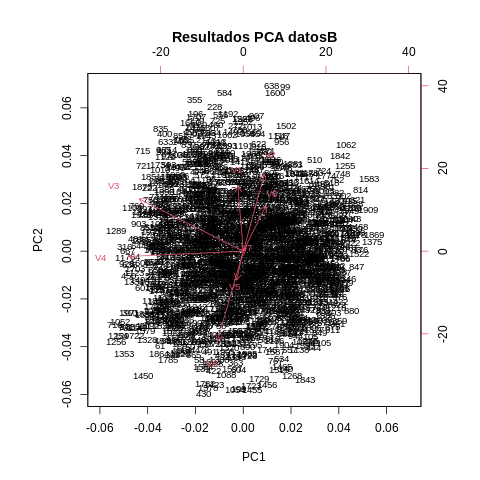

In [ ]:
datosB[1:5,]
datosB.x <- datosB[,-9]
datosB.y <- datosB[,9]

datosB.pca <- prcomp(datosB.x, scale=TRUE)
biplot(datosB.pca,choices=c(1,2),cex=0.8, main='Resultados PCA datosB')

Para este conjunto de datos, el gráfico también es difícil de observar pero se nota con mayor facilidad la separación de las variables. Se pueden ver agrupaciones de:
- V3 y V4
- V1, V2 y V6
- V5 y V8

### Selección de variables



In [ ]:
cat("\n > Forward ranking RF \n")
FORW.rf <- forward.ranking(datosB.x,datosB.y,method="rf.est" ,tot.trees=100,equalize.classes=F, verbosity=2)
cat("\n > Forward ranking LDA \n")
FORW.lda <- forward.ranking(datosB.x,datosB.y,method="lda.est", verbosity=2)

cat("\n ----------------------------------------- \n")

cat("\n > Backward ranking RF \n")
BACK.rf <- backward.ranking(datosB.x,datosB.y,method="rf.est" ,tot.trees=100,equalize.classes=F, verbosity=2)
cat("\n > Backward ranking LDA \n")
BACK.lda <- backward.ranking(datosB.x,datosB.y,method="lda.est", verbosity=2)

cat("\n ----------------------------------------- \n")

cat("\n > Kruskal-Wallis \n")
KW <- kruskal.ranking(datosB.x, datosB.y, verbosity = 2)

cat("\n ----------------------------------------- \n")

cat("\n > RFE random forest \n")
RFE.rf <- rfe.ranking(datosB.x,datosB.y,method="imp.rf", tot.trees=100, verbosity=2)
cat("\n > RFE SVM \n")
RFE.linsvm <- rfe.ranking(datosB.x,datosB.y,method="imp.linsvm", verbosity=2)


 > Forward ranking RF 

First feature:  3 

---------
Final ranking  8  features.
Features:  3 4 1 2 5 6 7 8 

 > Forward ranking LDA 

First feature:  4 

---------
Final ranking  8  features.
Features:  4 7 2 6 8 5 3 1 

 ----------------------------------------- 

 > Backward ranking RF 

Least important feature:  4 

---------
Final ranking  8  features.
Features:  1 2 8 6 7 5 3 4 

 > Backward ranking LDA 

Least important feature:  6 

---------
Final ranking  8  features.
Features:  4 7 5 3 8 1 2 6 

 ----------------------------------------- 

 > Kruskal-Wallis 

---------
Final ranking  8  features.
Features:  4 3 5 1 2 8 6 7 

 ----------------------------------------- 

 > RFE random forest 

---------
Final ranking  8  features.
Features:  1 2 3 4 8 6 5 7 

 > RFE SVM 

---------
Final ranking  8  features.
Features:  4 3 5 1 8 7 2 6 


Los resultados para este conjunto son un poco más variados. Se puede ver que la variable más importante elegida fue la 1, 3 o 4, predominando la 4. Salvo backward ranking y RFE (ambas en el caso donde se usó random forest), el resto todos los métodos prefirieron las variables 3 y 4; y estos 2 métodos eligieron correctamente la 1 y la 2.


# Ejercicio 3

## Funciones TP1 y auxiliares

In [7]:
generate_dataframe <- function(center1, center2, std_dev, d, n){
    cov_matrix = diag(rep(std_dev, times=d))
    points0 = mvrnorm(floor(n / 2), center1, cov_matrix)
    points1 = mvrnorm(ceiling(n / 2), center2, cov_matrix)
    clase0 = cbind(points0, rep(0, times=floor(n / 2)))
    clase1 = cbind(points1, rep(1, times=ceiling(n / 2)))
    return(rbind(clase0, clase1))
}

generate_diagonal <- function(n, d, C){
    generate_dataframe(rep(-1, times=d), rep(1, times=d), C * sqrt(d), d, n)
}

renombrar_nombres_columnas <- function(start, end, true_variables_number){
  nombres <- double((end-start) + 1)
  for(i in start:end){
    nombres[i-true_variables_number] <- as.character(i)
  }
  return(nombres)
}

porcentaje_aciertos_ranking <- function(true_variables, variables_ranking){
    cant <- 0
    true_variables_number <- length(true_variables)
    top_vars <- variables_ranking[1:true_variables_number]
    for(i in 1:true_variables_number){
        if(true_variables[i] %in% top_vars){
            cant <- cant + 1
        }
    }

    return(cant / 10)
}

In [8]:
# Generación datos

datos <- generate_diagonal(100, 10, 2)
x <- datos[,-11]
y <- datos[,11]
# Guardo como se llaman las variables verdaderas
true_variables <- 1:10

# Creo las 90 variables de ruido uniforme
datos_ruidosos = crea.ruido.unif(50, 90)
datos_ruidosos = datos_ruidosos[-91]
colnames(datos_ruidosos) = renombrar_nombres_columnas(11, 100, 10)
x.datos = cbind(x, datos_ruidosos)

In [9]:
# Experimento
experimento <- function(method, method.args, ...){
    porcentajes <- c()
    for(i in 1:30){
      ranking <- do.call(method, c(method.args, list(...)))
      porcentajes[i] <- porcentaje_aciertos_ranking(true_variables, ranking)
    }
    promedio_aciertos <- mean(porcentajes)
    return(list(porcentajes=porcentajes, promedio=promedio_aciertos))
}

mostrar_resultado_metodo <- function(resultado){
    porcentajes <- resultado$porcentajes
    aciertos_promedio <- resultado$promedio
    print("Porcentajes en cada iteración:")
    cat(porcentajes, "\n")
    print("Porcentaje promedio final:")
    cat(aciertos_promedio, "\n")
}

In [10]:
# Resultados
print("------------------Filtro Kruskal----------------------")
res.kruskal <- experimento(method="kruskal.ranking", list(x.datos, y))
mostrar_resultado_metodo(res.kruskal)
print("------------------Forward ranking RF----------------------")
res.fw <- experimento(method="forward.ranking", list(x.datos, as.factor(y), method="rf.est",tot.trees=100,equalize.classes=F))
mostrar_resultado_metodo(res.fw)
print("------------------RFE RF----------------------")
res.rfe <- experimento(method="rfe.ranking", list(x.datos, as.factor(y), method="imp.rf", tot.trees=100,equalize.classes=F))
mostrar_resultado_metodo(res.rfe)
print("------------------Backward ranking RF----------------------")
res.bw <- experimento(method="backward.ranking", list(x.datos, as.factor(y), method="rf.est" ,tot.trees=100))
mostrar_resultado_metodo(res.bw)


[1] "------------------Filtro Kruskal----------------------"
[1] "Porcentajes en cada iteración:"
0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 
[1] "Porcentaje promedio final:"
0.9 
[1] "------------------Forward ranking RF----------------------"
[1] "Porcentajes en cada iteración:"
0.6 0.3 0.4 0.6 0.4 0.5 0.2 0.6 0.5 0.3 0.5 0.3 0.2 0.4 0.3 0.4 0.3 0.6 0.3 0.5 0.6 0.5 0.5 0.4 0.5 0.2 0.6 0.4 0.4 0.2 
[1] "Porcentaje promedio final:"
0.4166667 
[1] "------------------RFE RF----------------------"
[1] "Porcentajes en cada iteración:"
0.9 0.9 0.9 0.9 1 1 0.9 0.9 1 0.8 1 1 0.9 1 0.9 0.9 0.8 1 1 0.8 1 0.9 1 0.9 0.9 0.9 0.9 1 0.9 0.9 
[1] "Porcentaje promedio final:"
0.9266667 
[1] "------------------Backward ranking RF----------------------"
[1] "Porcentajes en cada iteración:"
0.6 0.5 0.5 0.5 0.5 0.3 0.5 0.6 0.3 0.5 0.4 0.5 0.5 0.6 0.4 0.5 0.6 0.4 0.5 0.5 0.3 0.8 0.6 0.6 0.6 0.5 0.3 0.6 0.4 0.4 
[1] "Porcentaje pro

Podemos observar que para el método de Kruskal y para RFE los resultados son muy buenos, ya que 90% de las variables no ruidosas están el los primeros 10 lugares del ranking. Para forward ranking y backward ranking se observa una mayor sensibilidad al ruido, ya que solo 40 a 50% de las variables importantes están en el top 10 del ranking.

# Ejercicio 4



Para este ejercicio se utilizó un dataset obtenido en el siguiente link https://www.kaggle.com/datasets/bhavikjikadara/heart-failure-prediction, el cual contiene información sobre una pequeña población, y establece si se tuvo problemas con el corazón o no basado en las siguientes variables:
- Edad [años]
- anemia
- creatinina
- diabetes
- FEY : básicamente la sangre que eyecta el corazón (tuve que consultar con un experto en los datos a.k.a una amiga que sacó la matrícula de médica hace unos meses, ya que no sabía bien cómo traducir ejection_fraction)
- Presión sanguínea alta
- Plaquetas
- Creatinina sérica
- Sodio sérico
- Sexo: sexo biológico del paciente [1: Masculino, 0: Femenino]
- Fumador/a
- Tiempo (no documentan bien de qué)
- DEATH_EVENT: output class [1: heart disease, 0: Normal]

A priori pensaría que la presión sanguínea y si es fumador/a tendría que influir bastante en el output final.

Primero leemos el dataset y corroboramos brevemente que se haya cargado correctamente:

In [9]:
hd.dataset <- read.csv("heart_failure_clinical_records.csv")
hd.dataset[1:5,]

  age anaemia creatinine_phosphokinase diabetes ejection_fraction
1  75       0                      582        0                20
2  55       0                     7861        0                38
3  65       0                      146        0                20
4  50       1                      111        0                20
5  65       1                      160        1                20
  high_blood_pressure platelets serum_creatinine serum_sodium sex smoking time
1                   1    265000              1.9          130   1       0    4
2                   0    263358              1.1          136   1       0    6
3                   0    162000              1.3          129   1       1    7
4                   0    210000              1.9          137   1       0    7
5                   0    327000              2.7          116   0       0    8
  DEATH_EVENT
1           1
2           1
3           1
4           1
5           1


Ahora procedemos a hacer un biplot

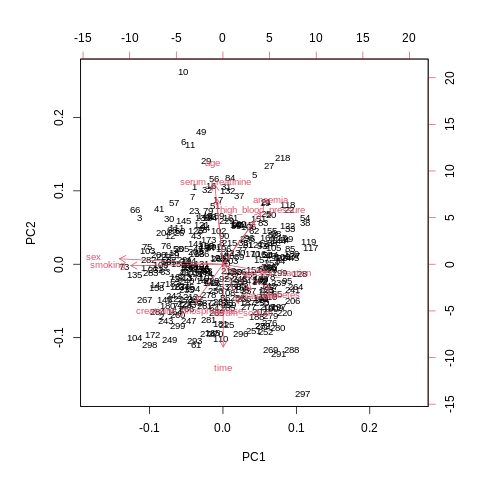

In [11]:
hd.dataset.x <- hd.dataset[,-13]
hd.dataset.y <- hd.dataset[,13]
hd.dataset.pca <- prcomp(hd.dataset.x, scale=TRUE)
biplot(hd.dataset.pca, cex=0.8)

En la zona inferior del gráfico es un poco difícil ver a las variables que residen, pero se pueden observar las siguientes agrupaciones:
- Edad y Serum de creatinina
- Anemia y Presión alta
- Tiempo
- Sexo y Fumador/a

Pasamos ahora a hacer una selección de variables para ver con un poco más de detalle la situación

In [16]:
cat("\n > RFE random forest \n")
RFE.rf <- rfe.ranking(hd.dataset.x,as.factor(hd.dataset.y),method="imp.rf", tot.trees=100, verbosity=2)


 > RFE random forest 

---------
Final ranking  12  features.
Features:  12 8 5 1 9 11 4 2 10 3 7 6 


Podemos observar que la varible elegida como más importante fue la 12, la "time". Una pena que no esté bien documentada, ya que por los valores que toma en los datos puede ser muchas cosas, por ejemplo meses que fumó o similar relacionado a otra variable. La siguiente elegida fue la creatinina sérica, mi experta en los datos me dijo que es para la función renal, así que tendrá una influencia quizás en esto. La 3era elegida fue la FEY (la sangre que eyecta al corazón), si está disminuido significa que tiene insuficiencia cardíaca con lo cual tiene mucho sentido que tome un lugar importante.